In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from pltconfig import *

In [2]:
# This is the raw data from the Spark plate reader for the tests of different rubiscos. 
# Both files have the same columns.
multi_rub_amb_df = pd.read_csv('data/sup_figs/071920_ED_OD600_ON_ambientCO2.csv', index_col=0)
multi_rub_5pct_df = pd.read_csv('data/sup_figs/071420_ED_OD600_ON_5pctCO2.csv', index_col=0)

# This is the raw data from the Spark plate reader for tests of the Hnea FIA rubisco at variable pCO2.
# This one is a double transformant CCMB1:p1A+vec because it was a control for a double transformation 
# experiment. As such, the growth curves are not directly comparable to those for other rubiscos.
hn_pt5pct_df = pd.read_csv('data/sup_figs/variable_pCO2/041919_gly_growth_0.5pctCO2.csv', index_col=0)
hn_1pct_df = pd.read_csv('data/sup_figs/variable_pCO2/040619_gly_growth_1pctCO2.csv', index_col=0)
hn_5pct_df = pd.read_csv('data/sup_figs/variable_pCO2/032719_gly_growth_5pctCO2.csv', index_col=0)

all_dfs = [multi_rub_5pct_df, multi_rub_amb_df, hn_5pct_df, hn_1pct_df, hn_pt5pct_df]
hn_dfs = [hn_5pct_df, hn_1pct_df, hn_pt5pct_df]

# Note: ambient data reports a CO2 concentration, but ambient CO2 is well beneath the
# measurement range of the Tecan Spark gas controllers sensor (bottom end ≈0.5% CO2).
hn_5pct_df.head()

,time_s,BLANK,BLANK.1,BLANK.2,BLANK.3,BLANK.4,BLANK.5,BLANK.6,BLANK.7,BLANK.8,...,LS/AGFP.6,LS/AGFP.7,K/AGFP,K/AGFP.1,K/AGFP.2,K/AGFP.3,K/AGFP.4,K/AGFP.5,K/AGFP.6,K/AGFP.7
0,0.000,0.04922,0.05128,0.06376,0.05620,0.05028,0.05046,0.06460,0.07190,0.05252,...,0.05722,0.06646,0.06012,0.06852,0.07228,0.06678,0.05842,0.06958,0.05944,0.06270
1,1921.890,0.04984,0.05232,0.06830,0.05866,0.05126,0.05160,0.07104,0.07788,0.05398,...,0.05804,0.06902,0.06022,0.07072,0.07502,0.06720,0.06028,0.07524,0.06006,0.06638
2,3843.967,0.04972,0.05246,0.07016,0.05976,0.05178,0.05192,0.07378,0.08208,0.05422,...,0.05858,0.07112,0.06050,0.07308,0.07748,0.06966,0.06206,0.08270,0.06090,0.06842
3,5765.890,0.04978,0.05332,0.07180,0.06098,0.05152,0.05222,0.07514,0.08394,0.05450,...,0.05896,0.07102,0.06088,0.07388,0.08000,0.07250,0.06316,0.08886,0.06246,0.07726
4,7687.981,0.04990,0.05340,0.07332,0.06146,0.05170,0.05200,0.07696,0.08516,0.05460,...,0.06024,0.07224,0.06148,0.07758,0.08246,0.07386,0.06426,0.08444,0.06462,0.07856


In [3]:
# Blank and smooth all the measurements
for my_df in all_dfs:
    od_cols = my_df.columns[1:]

    # Calculate the mean value for all blanks, subtract off
    blank_cols = [c for c in od_cols if c.startswith('BLANK')]
    mean_blank = my_df[blank_cols].mean().mean()
    my_df[od_cols] -= mean_blank
    
    # Smoothing is windowed mean twice over a 3 measurement window
    my_df[od_cols] = my_df[od_cols].rolling(3, min_periods=1).apply(np.nanmean)
    my_df[od_cols] =  my_df[od_cols].rolling(3, min_periods=1).apply(np.nanmean)


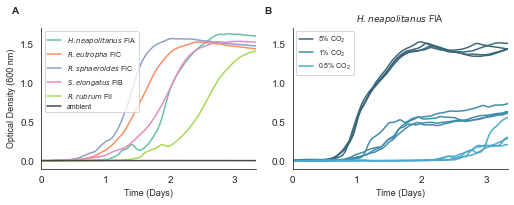

In [4]:
# Figure 2 supplement 4 illustrates two points.
# 1. Not important which rubisco you use to complement CCMB1 (panel A).
# 2. Complementation depends on the amount of CO2 in the growth environment as predicted (B).
order = ['CCMB1:p1A',
         'CCMB1:pFE-Reu-FI-prk',
         'CCMB1:pFE-Rs-FI-prk',
         'CCMB1:pFE-Selo-FI-prk',
         'CCMB1:pFE-Rrub-FII-prk',] 
sample_names = {
                'CCMB1:p1A': '$H. neapolitanus$ FIA',
                'CCMB1:p1A K194M': '$H. neapolitanus$ K194M',
                'CCMB1:pFE-Reu-FI-prk': '$R. eutropha$ FIC',
                'CCMB1:pFE-Rrub-FII-prk': '$R. rubrum$ FII',
                'CCMB1:pFE-Rs-FI-prk': '$R. sphaeroides$ FIC',
                'CCMB1:pFE-Selo-FI-prk': '$S. elongatus$ FIB',
                }
panel_labels = 'AB'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7.25, 3))
sns.set_style('white')

time_h_amb = multi_rub_amb_df.time_s/3600
time_h_5pct = multi_rub_5pct_df.time_s/3600
pal = sns.color_palette('Set2')

ax = axs[0]
plt.sca(ax)
for i, sample in enumerate(order):
    bio_rep = '%s.1' % sample
    name = sample_names[sample]
    
    ax.plot(time_h_5pct, multi_rub_5pct_df[bio_rep], c=pal[i], label=name)
    if i == len(order) - 1:
        ax.plot(time_h_amb, multi_rub_amb_df[bio_rep], c=greys[-2], label='ambient')

    
plt.legend(fontsize=7)
plt.yticks(np.arange(0, 1.6, 0.5))
plt.xticks(np.arange(0, 73, 24), np.arange(0, 4))
plt.ylabel('Optical Density (600 nm)', fontsize=9)
plt.xlabel('Time (Days)', fontsize=9)
plt.ylim(-0.1, 1.7)
plt.xlim(0, 80)
sns.despine(ax=ax)
    
names2plot = ['LS/AGFP'] + ['LS/AGFP.%s' % i for i in '136']
ax = axs[1]
plt.sca(ax)
pCO2s = ['5% CO$_2$', '1% CO$_2$', '0.5% CO$_2$']
for i, my_df in enumerate(hn_dfs):
    my_time_h = my_df.time_s / 3600
    
    for j, col in enumerate(names2plot):
        label = None
        if j == 0:
            label = pCO2s[i]
        ax.plot(my_time_h, my_df[col], c=blue_greens[-2*i-3], label=label)
    
plt.legend(fontsize=7)
plt.ylim(-0.1, 1.7)
plt.xlim(0, 80)
plt.yticks(np.arange(0, 1.6, 0.5))
plt.xticks(np.arange(0, 73, 24), np.arange(0, 4))
plt.xlabel('Time (Days)', fontsize=9)
plt.title('$H. neapolitanus$ FIA', fontsize=9)
sns.despine(ax=ax)

for i, ax in enumerate(axs.flatten()):
    ax.text(-0.1, 1.15, panel_labels[i], transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')
    
plt.tight_layout()
plt.savefig('fig2/fig2S4.png', dpi=300)
plt.show()